# Book Recommendation System

## Import Library

In [2]:
!pip install kaggle pandas scikit-learn tensorflow matplotlib unzip

In [164]:
# Basic utility libraries
import os          # for interacting with the operating system (e.g., paths)
import shutil      # for file operations like copying
import zipfile     # for extracting zip files
import re          # for regex
from collections import defaultdict
from math import floor
from IPython.display import display, Image 
import random

# Data handling and analysis
import pandas as pd       # for working with tabular data (DataFrames)
import numpy as np        # for numerical operations and array handling

# Data visualization
import matplotlib.pyplot as plt  # for plotting graphs and charts
import seaborn as sns            # for statistical visualizations and styling

# Content-Based Filtering (CBF)  tools
from sklearn.feature_extraction.text import TfidfVectorizer  #TF-IDF 
from sklearn.metrics.pairwise import cosine_similarity # cosine similarity

# Deep Learning (for Collaborative Filtering)
from sklearn.preprocessing import LabelEncoder # Encode data
from sklearn.model_selection import train_test_split
import tensorflow as tf                      # core TensorFlow library
import keras                                 # high-level API for building models
from keras import layers                     # used to define neural network layers
from keras import ops                        # Provides mathematical operations for custom model building

## Data Loading 

In [4]:
!kaggle datasets download -d arashnic/book-recommendation-dataset # Download dataset from Kaggle

Dataset URL: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset
License(s): CC0-1.0


In [5]:
!unzip book-recommendation-dataset.zip -d dataset #unzip dataset

Archive:  book-recommendation-dataset.zip
  inflating: dataset/Books.csv       
  inflating: dataset/DeepRec.png     
  inflating: dataset/Ratings.csv     
  inflating: dataset/Users.csv       
  inflating: dataset/classicRec.png  
  inflating: dataset/recsys_taxonomy2.png  


In [6]:
books = pd.read_csv("dataset/Books.csv")
users = pd.read_csv("dataset/Users.csv")
ratings = pd.read_csv("dataset/Ratings.csv")

print(f"Books: {books.shape[0]} data | Unique ISBN: {books['ISBN'].nunique()}")
print(f"Users: {users.shape[0]} data | Unique User-ID: {users['User-ID'].nunique()}")
print(f"Ratings: {ratings.shape[0]} data | Unique User-ID: {ratings['User-ID'].nunique()}")

/var/folders/3q/m608zwdn7_3_d0cjdkbqsbm40000gn/T/ipykernel_64307/1549839683.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv("dataset/Books.csv")


Books: 271360 data | Unique ISBN: 271360
Users: 278858 data | Unique User-ID: 278858
Ratings: 1149780 data | Unique User-ID: 105283


## Data Understanding - Univariate Exploratory Data Analysis (EDA) 

### Books Variable

In [7]:
books.info() # show structure and types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [8]:
books.describe() 

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
count,271360,271360,271358,271360,271358,271360,271360,271357
unique,271360,242135,102022,202,16807,271044,271044,271041
top,0195153448,Selected Poems,Agatha Christie,2002,Harlequin,http://images.amazon.com/images/P/185326119X.0...,http://images.amazon.com/images/P/185326119X.0...,http://images.amazon.com/images/P/225307649X.0...
freq,1,27,632,13903,7535,2,2,2


In [9]:
# Number of unique values in key columns
print(f"\nUnique ISBNs: {books['ISBN'].nunique()}")
print(f"Unique Titles: {books['Book-Title'].nunique()}")
print(f"Unique Authors: {books['Book-Author'].nunique()}")
print(f"Unique Publishers: {books['Publisher'].nunique()}")


Unique ISBNs: 271360
Unique Titles: 242135
Unique Authors: 102022
Unique Publishers: 16807


In [10]:
print("Missing values in Books:")
print(books.isnull().sum(), "\n") # Check missing value

Missing values in Books:
ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64 



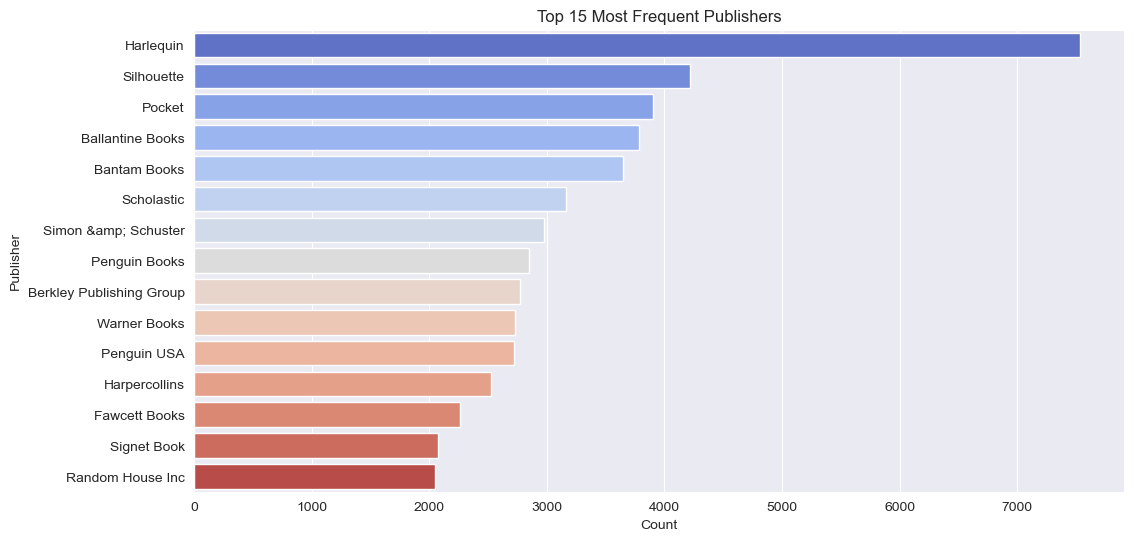

In [11]:
# Top 15 Publishers
top_publishers = books['Publisher'].value_counts().head(15)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_publishers.values, y=top_publishers.index, hue=top_publishers.index, legend=False, palette="coolwarm")
plt.title("Top 15 Most Frequent Publishers")
plt.xlabel("Count")
plt.ylabel("Publisher")
plt.show()

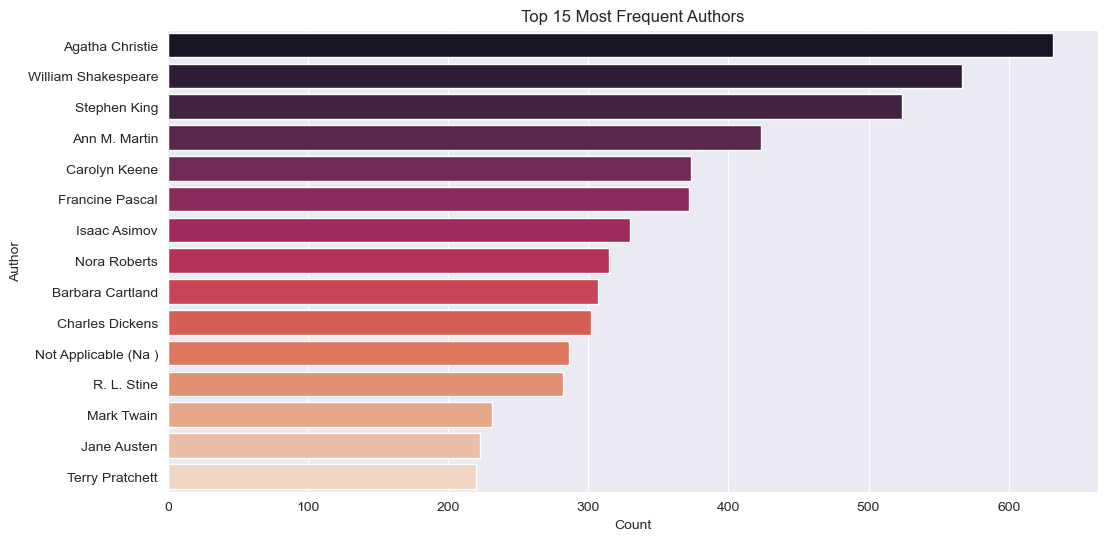

In [12]:
# Top 15 Authors
top_authors = books['Book-Author'].value_counts().head(15)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_authors.values, y=top_authors.index, hue=top_authors.index, legend=False, palette="rocket")
plt.title("Top 15 Most Frequent Authors")
plt.xlabel("Count")
plt.ylabel("Author")
plt.show()

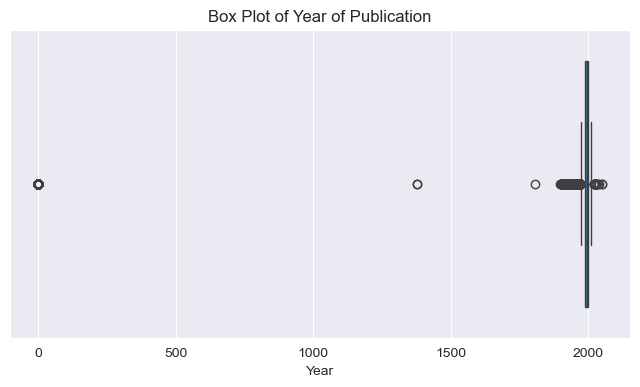

In [13]:
# Check outlier 
temp_books = books.copy()
temp_books['Year-Of-Publication'] = pd.to_numeric(temp_books['Year-Of-Publication'], errors='coerce')


plt.figure(figsize=(8, 4))
sns.boxplot(x=temp_books['Year-Of-Publication'].dropna() )
plt.title("Box Plot of Year of Publication")
plt.xlabel("Year")
plt.show()

### Users Variable 

In [14]:
users.info() # Preview structure and types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [15]:
users.describe() # Summary statistics

,User-ID,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


In [16]:
print(f"\nUnique Users: {users['User-ID'].nunique()}")
print(f"Unique Locations: {users['Location'].nunique()}")


Unique Users: 278858
Unique Locations: 57339


In [17]:
print("Missing values in Users:")
print(users.isnull().sum(), "\n") # Check missing value

Missing values in Users:
User-ID          0
Location         0
Age         110762
dtype: int64 



####  User Age Group Distribution

To provide a clearer view of user demographics, the users are grouped users  four age categories:

- **Child**: 5–12 years old
- **Teenager**: 13–20 years old
- **Adult**: 21–59 years old
- **Senior**: 60+ years old

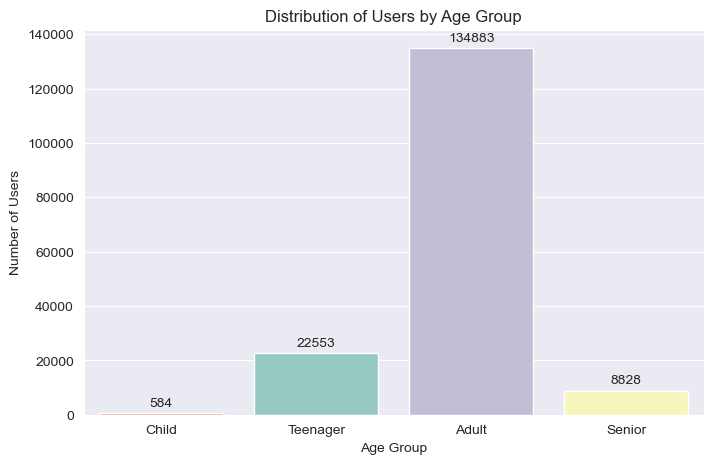

In [18]:
# Filter users with a realistic age range (5 to 100 years)
filtered_users = users[(users['Age'] >= 5) & (users['Age'] <= 100)].copy()

# Define age group categories
def get_age_group(age):
    if age <= 12:
        return 'Child'
    elif age <= 20:
        return 'Teenager'
    elif age <= 59:
        return 'Adult'
    else:
        return 'Senior'

# Apply age group categorization
filtered_users['AgeGroup'] = filtered_users['Age'].apply(get_age_group)


plt.figure(figsize=(8, 5))
ax = sns.countplot(data=filtered_users, x='AgeGroup', order=['Child', 'Teenager', 'Adult', 'Senior'], palette='Set3', hue='AgeGroup', legend=False)

# Add data labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)
    
plt.title("Distribution of Users by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Number of Users")
plt.show()

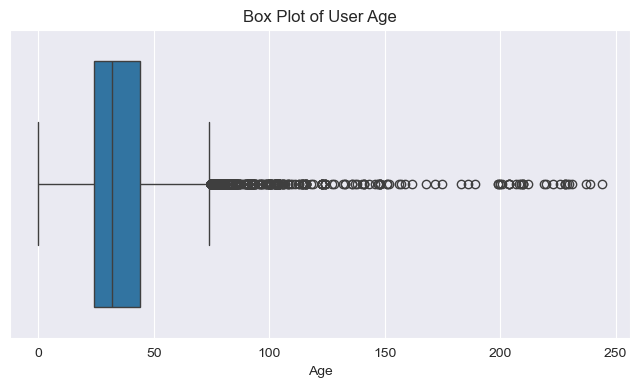

In [19]:
# Checking outliers on user based on age
plt.figure(figsize=(8, 4))
sns.boxplot(x=users['Age'])
plt.title("Box Plot of User Age")
plt.xlabel("Age")
plt.show()

# Ratings Variable

In [20]:
ratings.info() # Preview structure and types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [21]:
ratings.describe() # show summary

,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


In [22]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [23]:
print(f"\nUnique User-ID: {ratings['User-ID'].nunique()}")
print(f"Unique ISBN: {ratings['ISBN'].nunique()}")
print(f"Most common rating: \n{ratings['Book-Rating'].value_counts().sort_index()}")


Unique User-ID: 105283
Unique ISBN: 340556
Most common rating: 
Book-Rating
0     716109
1       1770
2       2759
3       5996
4       8904
5      50974
6      36924
7      76457
8     103736
9      67541
10     78610
Name: count, dtype: int64


#### Distribution of Book Ratings per User 

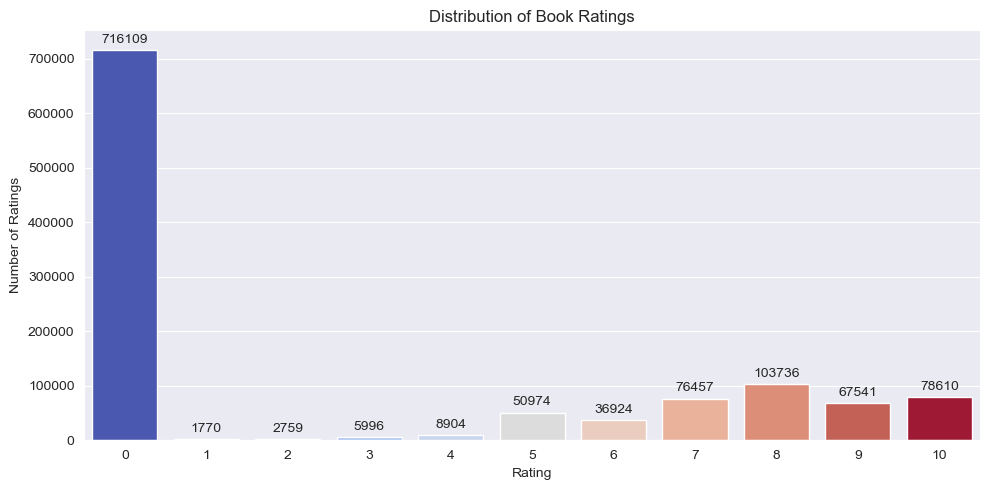

In [24]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Book-Rating', hue='Book-Rating', legend=False, data=ratings, palette='coolwarm')
plt.title("Distribution of Book Ratings")
plt.xlabel("Rating")
plt.ylabel("Number of Ratings")

# Add exact number above bars
ax = plt.gca()
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

plt.tight_layout()
plt.show()

In [25]:
# Print the distribution of ratings from 0 to 10
rating_distribution = ratings['Book-Rating'].value_counts().sort_index()

# Display the distribution
print("Distribution of Ratings (0-10):")
print(rating_distribution)

Distribution of Ratings (0-10):
Book-Rating
0     716109
1       1770
2       2759
3       5996
4       8904
5      50974
6      36924
7      76457
8     103736
9      67541
10     78610
Name: count, dtype: int64


## Data Preprocessing


### Books Variable Cleaning

#### Handling missing values

In [26]:
print("Missing values in books before handling:")
print(books.isnull().sum())

Missing values in books before handling:
ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64


In [27]:
# Fill the missing values in Book-Author and Publisher with Unknown
books['Book-Author'] = books['Book-Author'].fillna('Unknown')
books['Publisher'] = books['Publisher'].fillna('Unknown')

In [28]:
# Drop missing values on Image-URL-L
books = books[books['Image-URL-L'].notnull()]

In [29]:
print("Missing values in books after handling:")
print(books.isnull().sum())
print(f"Final shape: {books.shape}")

Missing values in books after handling:
ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
dtype: int64
Final shape: (271357, 8)


### 

#### Year Of Publication Outlier Handling

In [30]:
# Copy and convert year column to numeric
temp_books = books.copy()
temp_books['Year-Of-Publication'] = pd.to_numeric(temp_books['Year-Of-Publication'], errors='coerce')

In [31]:
# Drop NaN for analysis
year_data = temp_books['Year-Of-Publication'].dropna()

In [32]:
# Handling the Outlier with IQR
Q1 = year_data.quantile(0.25)
Q3 = year_data.quantile(0.75)
IQR = Q3 - Q1

# Define acceptable range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"IQR: {IQR}")
print(f"Acceptable Year Range: {int(lower_bound)} to {int(upper_bound)}")

IQR: 11.0
Acceptable Year Range: 1972 to 2016


In [33]:
# Apply only years within the IQR range
books = temp_books[(temp_books['Year-Of-Publication'] >= lower_bound) & 
                   (temp_books['Year-Of-Publication'] <= upper_bound)]

print(f"Remaining data shape after outlier removal: {books.shape}")

Remaining data shape after outlier removal: (262262, 8)


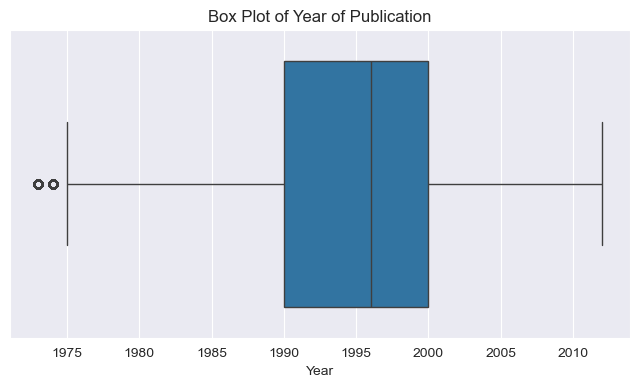

In [34]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=books['Year-Of-Publication'])
plt.title("Box Plot of Year of Publication")
plt.xlabel("Year")
plt.show()

### Users Variable

#### Handling Outlier and Missing Values in Age

In [35]:
# Copy and filter the valid age ranges
users_cleaned = users.copy()
users_cleaned = users_cleaned[(users_cleaned['Age'] >= 5) & (users_cleaned['Age'] <= 100)]


In [36]:
# Fill remaining missing values with median age (from within the range)
median_age = users_cleaned['Age'].median()
users_cleaned['Age'].fillna(median_age)

print(f"Users cleaned shape: {users_cleaned.shape}")

Users cleaned shape: (166848, 3)


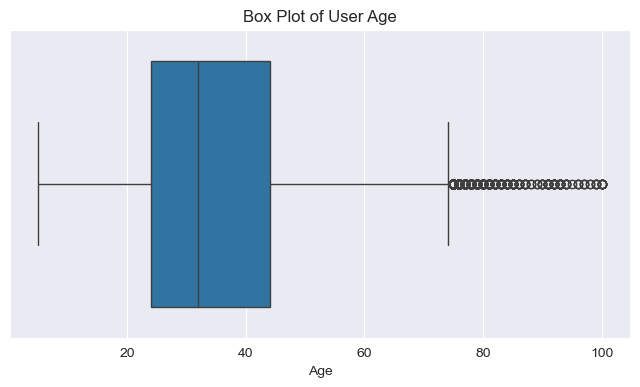

In [37]:
# Checking outliers on user based on age
plt.figure(figsize=(8, 4))
sns.boxplot(x=users_cleaned['Age'])
plt.title("Box Plot of User Age")
plt.xlabel("Age")
plt.show()

### Ratings Variable

### Drop Rating 0
Users have read the book, but they don't give the feedback. So, rating 0 is dropped

In [38]:
ratings_cleaned = ratings[ratings['Book-Rating'] > 0].copy()
print(f"Ratings after removing 0s: {ratings_cleaned.shape}")

Ratings after removing 0s: (433671, 3)


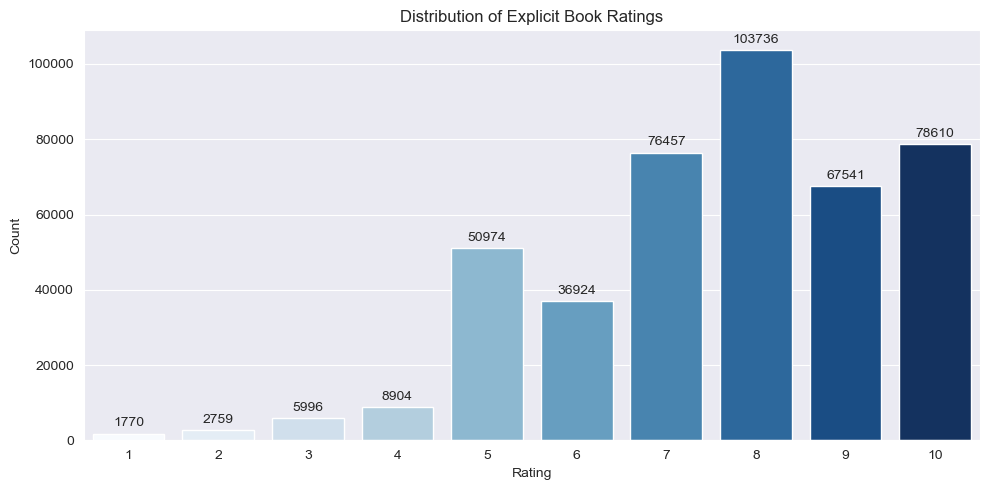

In [39]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Book-Rating', hue='Book-Rating', legend=False, data=ratings_cleaned, palette='Blues')
plt.title("Distribution of Explicit Book Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")

# Add labels on bars
ax = plt.gca()
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

plt.tight_layout()
plt.show()

## Data Preparation
All variable data is merged to be used in both Collaborative Filtering (CF) and Content-Based Filtering (CBF). It can be flexibly used for both models.

In [40]:
# Merger Ratings and Books
ratings_books = ratings_cleaned.merge(books, on='ISBN', how='inner')
print(f"Merged (ratings + books): {ratings_books.shape}")

Merged (ratings + books): (373410, 10)


In [41]:
# Merger with users
full_data = ratings_books.merge(users_cleaned, on='User-ID', how='inner')
print(f"Final merged shape (ratings + books + users): {full_data.shape}")

Final merged shape (ratings + books + users): (260647, 12)


In [42]:
full_data.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Location,Age
0,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...,"rijeka, n/a, croatia",16.0
1,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,"rijeka, n/a, croatia",16.0
2,276747,0060517794,9,Little Altars Everywhere,Rebecca Wells,2003,HarperTorch,http://images.amazon.com/images/P/0060517794.0...,http://images.amazon.com/images/P/0060517794.0...,http://images.amazon.com/images/P/0060517794.0...,"iowa city, iowa, usa",25.0
3,276747,0671537458,9,Waiting to Exhale,Terry McMillan,1995,Pocket,http://images.amazon.com/images/P/0671537458.0...,http://images.amazon.com/images/P/0671537458.0...,http://images.amazon.com/images/P/0671537458.0...,"iowa city, iowa, usa",25.0
4,276747,0679776818,8,Birdsong: A Novel of Love and War,Sebastian Faulks,1997,Vintage Books USA,http://images.amazon.com/images/P/0679776818.0...,http://images.amazon.com/images/P/0679776818.0...,http://images.amazon.com/images/P/0679776818.0...,"iowa city, iowa, usa",25.0


## Modelling

### Model Development with Content Based Filtering

In [127]:
# Create a copy of full_data for CBF modeling and using used columns
cbf_data = full_data[['Book-Title', 'Book-Author', 'Publisher', 'Image-URL-L']].drop_duplicates()
cbf_data = cbf_data.drop_duplicates(subset=['Book-Title', 'Book-Author'], keep='first').reset_index(drop=True)

In [128]:
#Combine book title and author for TF-IDF
cbf_data['combined_features'] = cbf_data['Book-Title'] + ' ' + cbf_data['Book-Author']
cbf_data['combined_features'] = cbf_data['combined_features'].fillna('')

In [129]:
# Using TF-IDF
tfidf = TfidfVectorizer()

tfidf_matrix = tfidf.fit_transform(cbf_data['combined_features'])

vocab = tfidf.get_feature_names_out()

print(f"Unique features (token): {len(vocab)}")
print(vocab[:20])

Unique features (token): 71169
['00' '000' '001' '0017' '003' '007' '01' '011090' '013' '016' '0176' '02'
 '024' '0272' '02745' '028' '02tc0676' '03' '030' '037']


In [130]:
tfidf_matrix.shape

(108309, 71169)

In [122]:
# Create lowercase index mapping
cbf_data['Book-Title-Lower'] = cbf_data['Book-Title'].str.lower()
indices = pd.Series(cbf_data.index, index=cbf_data['Book-Title-Lower']).drop_duplicates()

In [123]:
def normalize_title(title):
    title = title.lower()
    title = re.sub(r'[^a-z\s]', '', title)  # remove digits/punctuation
    title = re.sub(r'\s+', ' ', title).strip()
    return title

In [180]:
def safe_display_image(url, width=100):
    if isinstance(url, str) and url.startswith('http'):
        try:
            display(Image(url=url, width=width))
        except:
            print("[Image not available]")
    else:
        print("[No image URL]")

In [185]:
def get_book_recommendations(title, k=5, max_author_ratio=0.3):
    """
    Return top-k diverse books based on TF-IDF cosine similarity.
    Limits max percentage of books from the same author.
    Excludes semantic duplicates based on normalized title + author.
    """
    title = title.lower()

    if title not in indices:
        print(f"Book title '{title}' not found in the dataset.")
        return

    idx = indices[title]
    if isinstance(idx, pd.Series):
        idx = idx.iloc[0]

    if idx >= tfidf_matrix.shape[0]:
        print(f"Index {idx} is out of range for the TF-IDF matrix.")
        return

    # Normalize input title and author
    input_title_norm = normalize_title(cbf_data.loc[idx, 'Book-Title'])
    input_author = cbf_data.loc[idx, 'Book-Author'].lower()

    # Compute cosine similarity
    sim_scores = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).flatten()
    top_indices = sim_scores.argsort()[::-1]

    # Author diversity filtering
    max_per_author = max(1, floor(k * max_author_ratio))
    author_counts = defaultdict(int)
    filtered = []

    # Filtering book to not same with the input
    for i in top_indices:
        if i == idx:
            continue

        candidate = cbf_data.iloc[i]
        candidate_title_norm = normalize_title(candidate['Book-Title'])
        candidate_author = candidate['Book-Author'].lower()

        # Skip duplicates
        if candidate_title_norm == input_title_norm and candidate_author == input_author:
            continue

        # Author diversity filter
        if author_counts[candidate_author] >= max_per_author:
            continue

        filtered.append(i)
        author_counts[candidate_author] += 1

        if len(filtered) == k:
            break

    if not filtered:
        print("No diverse recommendations found.")
        return

    # Display input book
    print("\nInput Book:")
    input_book = cbf_data.loc[idx]
    print(f"Title     : {input_book['Book-Title']}")
    print(f"Author    : {input_book['Book-Author']}")
    print(f"Publisher : {input_book['Publisher']}")
    safe_display_image(input_book['Image-URL-L'])

    print(f"\nTop {k} Recommendations:\n")
    
    for i, index in enumerate(filtered, start=1):
        rec = cbf_data.iloc[index]
        print(f"#{i}")
        print(f"Title     : {rec['Book-Title']}")
        print(f"Author    : {rec['Book-Author']}")
        print(f"Publisher : {rec['Publisher']}")
        safe_display_image(rec['Image-URL-L'])
        print("-" * 40)

In [186]:
get_book_recommendations("Harry Potter and the Prisoner of Azkaban")


Input Book:
Title     : Harry Potter and the Prisoner of Azkaban
Author    : J. K. Rowling
Publisher : Bloomsbury Pub Ltd



Top 5 Recommendations:

#1
Title     : Harry Potter and the Prisoner of Azkaban (Book 3)
Author    : J. K. Rowling
Publisher : Scholastic


----------------------------------------
#2
Title     : Harry Potter and the Prisoner of Azkaban (Harry Potter)
Author    : J.K. Rowling
Publisher : Scholastic Paperbacks


----------------------------------------
#3
Title     : Harry Potter and the Prisoner of Azkaban Color and Activity Book (Harry Potter)
Author    : Scholastic
Publisher : Scholastic


----------------------------------------
#4
Title     : Harry Potter, tome 3 : Harry Potter et le Prisonnier d'Azkaban
Author    : Joanne K. Rowling
Publisher : Gallimard


----------------------------------------
#5
Title     : J. K. Rowling: The Wizard Behind Harry Potter
Author    : Marc Shapiro
Publisher : St. Martin's Press


----------------------------------------


### Model Development with Collaborative Filtering (CF)

#### Data Understanding

In [138]:
# Get data for cf_data 
cf_data = full_data[['User-ID', 'ISBN', 'Book-Rating']].copy()

In [139]:
cf_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260647 entries, 0 to 260646
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   User-ID      260647 non-null  int64 
 1   ISBN         260647 non-null  object
 2   Book-Rating  260647 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 6.0+ MB


#### Data Preparation 
In data preparation, there are two steps:
1. Encode User-ID and ISBN to Integer 
2. Rename column with easy naming
3. Convert Book-Rating to float

In [141]:
# Encode User-ID and ISBN to Integer
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

cf_data['user'] = user_encoder.fit_transform(cf_data['User-ID'])
cf_data['item'] = item_encoder.fit_transform(cf_data['ISBN'])

In [142]:
# Cek result encode
cf_data.head()

,User-ID,ISBN,Book-Rating,user,item
0,276729,052165615X,3,39073,47812
1,276729,0521795028,6,39073,47830
2,276747,0060517794,9,39074,2322
3,276747,0671537458,9,39074,57889
4,276747,0679776818,8,39074,62078


In [143]:
# Convert rating to float
cf_data['rating'] = cf_data['Book-Rating'].astype(float)

In [144]:
# Get only used columns
cf_data = cf_data[['user', 'item', 'rating']]
cf_data.head()

,user,item,rating
0,39073,47812,3.0
1,39073,47830,6.0
2,39074,2322,9.0
3,39074,57889,9.0
4,39074,62078,8.0


In [145]:
# Count the number of unique users
num_users = cf_data['user'].nunique()

# Count the number of unique items (books)
num_items = cf_data['item'].nunique()

# Find the minimum and maximum rating values
min_rating = cf_data['rating'].min()
max_rating = cf_data['rating'].max()

# Display the results
print(f"Number of Users       : {num_users}")
print(f"Number of Items       : {num_items}")
print(f"Minimum Rating Value  : {min_rating}")
print(f"Maximum Rating Value  : {max_rating}")

Number of Users       : 39392
Number of Items       : 115503
Minimum Rating Value  : 1.0
Maximum Rating Value  : 10.0


#### Split Train and Testing Data
Split 80% Training, 20% Testing

In [147]:
# Create the input array X (pairs of user and item)
X = cf_data[['user', 'item']].values

# Normalize ratings to range [0, 1]
y = cf_data['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

In [148]:
# Split the data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X,           # Input: user-item pairs
    y,           # Target: normalized ratings
    test_size=0.2,
    random_state=42
)
print(f"X_train shape : {X_train.shape}")
print(f"X_test shape  : {X_test.shape}")
print(f"y_train shape : {y_train.shape}")
print(f"y_test shape  : {y_test.shape}")

X_train shape : (208517, 2)
X_test shape  : (52130, 2)
y_train shape : (208517,)
y_test shape  : (52130,)


#### Training

In [151]:
class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_items, embedding_size=50, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        
        # User embedding
        self.user_embedding = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(input_dim=num_users, output_dim=1)

        # Item embedding
        self.item_embedding = layers.Embedding(
            input_dim=num_items,
            output_dim=embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.item_bias = layers.Embedding(input_dim=num_items, output_dim=1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0]) # Call layer embedding 1
        user_bias = self.user_bias(inputs[:, 0])        # Call layer embedding 2
        item_vector = self.item_embedding(inputs[:, 1]) # Call layer embedding 3
        item_bias = self.item_bias(inputs[:, 1])        # Call layer embedding 4

        dot_user_item = tf.reduce_sum(user_vector * item_vector, axis=1, keepdims=True)
        result = dot_user_item + user_bias + item_bias

        return tf.nn.sigmoid(result)

In [154]:
# Get user and item dimensions
num_users = cf_data['user'].nunique()
num_items = cf_data['item'].nunique()

# Build model
model = RecommenderNet(num_users, num_items)
model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[
        tf.keras.metrics.RootMeanSquaredError(),
        tf.keras.metrics.MeanAbsoluteError()
    ]
)

In [155]:
# Training
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=64,
    epochs=10,
    verbose=1,
    validation_data=(X_test, y_test)
)

Epoch 1/10
3259/3259 ━━━━━━━━━━━━━━━━━━━━ 72s 22ms/step - loss: 0.0910 - mean_absolute_error: 0.2620 - root_mean_squared_error: 0.3010 - val_loss: 0.0660 - val_mean_absolute_error: 0.2149 - val_root_mean_squared_error: 0.2542
Epoch 2/10
3259/3259 ━━━━━━━━━━━━━━━━━━━━ 76s 23ms/step - loss: 0.0579 - mean_absolute_error: 0.1966 - root_mean_squared_error: 0.2362 - val_loss: 0.0533 - val_mean_absolute_error: 0.1849 - val_root_mean_squared_error: 0.2250
Epoch 3/10
3259/3259 ━━━━━━━━━━━━━━━━━━━━ 76s 23ms/step - loss: 0.0448 - mean_absolute_error: 0.1654 - root_mean_squared_error: 0.2047 - val_loss: 0.0471 - val_mean_absolute_error: 0.1717 - val_root_mean_squared_error: 0.2117
Epoch 4/10
3259/3259 ━━━━━━━━━━━━━━━━━━━━ 74s 23ms/step - loss: 0.0377 - mean_absolute_error: 0.1497 - root_mean_squared_error: 0.1883 - val_loss: 0.0430 - val_mean_absolute_error: 0.1635 - val_root_mean_squared_error: 0.2036
Epoch 5/10
3259/3259 ━━━━━━━━━━━━━━━━━━━━ 78s 24ms/step - loss: 0.0328 - mean_absolute_error: 0.

#### Visualize metrics

In [156]:
def plot_training_history(history):
    plt.figure(figsize=(14, 5))

    # Loss (MSE)
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Train Loss (MSE)')
    plt.plot(history.history['val_loss'], label='Val Loss (MSE)')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # RMSE
    plt.subplot(1, 3, 2)
    plt.plot(history.history['root_mean_squared_error'], label='Train RMSE')
    plt.plot(history.history['val_root_mean_squared_error'], label='Val RMSE')
    plt.title('RMSE per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)

    # MAE
    plt.subplot(1, 3, 3)
    plt.plot(history.history['mean_absolute_error'], label='Train MAE')
    plt.plot(history.history['val_mean_absolute_error'], label='Val MAE')
    plt.title('MAE per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

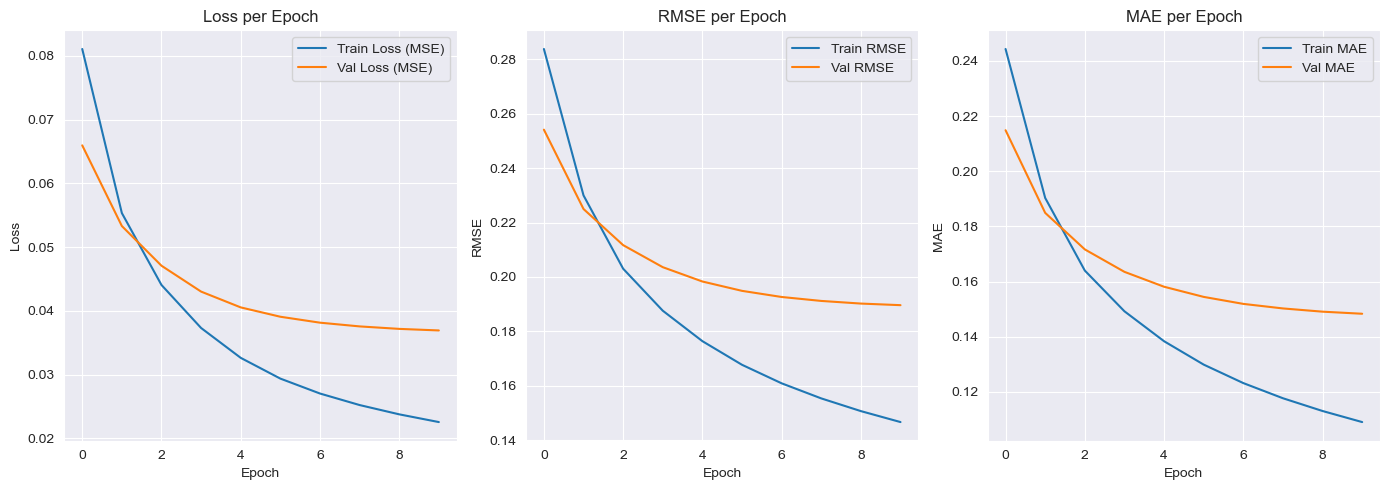

In [157]:
plot_training_history(history)

#### Get Books Recommendation

In [190]:
def show_high_rated_book_and_recommendation(original_user_id, top_k=5, min_rating=8.0, top_k_rating=3):
    # Encode user ID
    try:
        encoded_user_id = user_encoder.transform([original_user_id])[0]
    except ValueError:
        print(f"User-ID {original_user_id} not found in training data.")
        return pd.DataFrame()

    # Filter books rated ≥ min_rating by the user
    high_rated_df = cf_data[(cf_data['user'] == encoded_user_id) & (cf_data['rating'] >= min_rating)]
    
    # Sort by actual rating value (descending) and get top k__rating
    top_rated_df = high_rated_df.sort_values(by='rating', ascending=False).head(top_k_rating)
    
    # Decode item IDs to ISBNs
    high_rated_isbns = item_encoder.inverse_transform(top_rated_df['item'])
    
    # Lookup book details
    high_rated_books = books[books['ISBN'].isin(high_rated_isbns)][['Book-Title', 'Book-Author', 'Publisher', 'Image-URL-L']].drop_duplicates().reset_index(drop=True)
    
    print(f"\nTop {top_k_rating} Books rated ≥ {min_rating} by user {original_user_id}:\n")
    if high_rated_books.empty:
        print("No high-rated books found.")
    else:
        for i, row in high_rated_books.iterrows():
            print(f"#{i+1}: {row['Book-Title']} by {row['Book-Author']} ({row['Publisher']})")
            safe_display_image(row['Image-URL-L'])
            print("-" * 40)

    # Not rated Books → Recommendation
    user_all_rated_df = cf_data[cf_data['user'] == encoded_user_id]
    rated_items = user_all_rated_df['item'].values
    
    all_items = np.arange(num_items) # Create array
    unrated_items = np.setdiff1d(all_items, rated_items) # Get only unrated items from all items

    user_input = np.array([[encoded_user_id, item] for item in unrated_items]) # Create user - item to every unrated items
    
    #Predict using the model
    predicted_ratings = model.predict(user_input, verbose=0).flatten()

    top_indices = predicted_ratings.argsort()[-top_k:][::-1] # Get high prediction 
    
    recommended_item_ids = unrated_items[top_indices]
    recommended_isbns = item_encoder.inverse_transform(recommended_item_ids)
    
    # Get all recommendation book from books
    recommended_books = books[books['ISBN'].isin(recommended_isbns)][['Book-Title', 'Book-Author', 'Publisher', 'Image-URL-M']].drop_duplicates().reset_index(drop=True)

    print(f"\nTop {top_k} Book Recommendations for User {original_user_id}:\n")
    if recommended_books.empty:
        print("No recommendations available.")
    else:
        for i, row in recommended_books.iterrows():
            print(f"#{i+1}: {row['Book-Title']} by {row['Book-Author']} ({row['Publisher']})")
            safe_display_image(row['Image-URL-M'], width=100)
            print("-" * 40)

In [191]:
# Random users
unique_users = np.unique(X_train[:, 0])
original_user_ids = user_encoder.inverse_transform(unique_users)
random_user_id = random.choice(original_user_ids)
print(f"Get high rated books and recommendation for user ID: {random_user_id}")
show_high_rated_book_and_recommendation(random_user_id)

Get high rated books and recommendation for user ID: 259369

Top 3 Books rated ≥ 8.0 by user 259369:

No high-rated books found.

Top 5 Book Recommendations for User 259369:

#1: Lonesome Dove by Larry McMurtry (Pocket)


----------------------------------------
#2: The Return of the King (The Lord of the Rings, Part 3) by J.R.R. TOLKIEN (Del Rey)


----------------------------------------
#3: Dune (Remembering Tomorrow) by Frank Herbert (ACE Charter)


----------------------------------------
#4: Harry Potter and the Sorcerer's Stone (Book 1) by J. K. Rowling (Scholastic)


----------------------------------------
#5: My Sister's Keeper : A Novel (Picoult, Jodi) by Jodi Picoult (Atria)


----------------------------------------


In [192]:
show_high_rated_book_and_recommendation(110887)


Top 3 Books rated ≥ 8.0 by user 110887:

#1: In the Heart of the Sea: The Tragedy of the Whaleship Essex by Nat Philbrick (Penguin Books)


----------------------------------------
#2: Driven by W. G. Griffiths (Warner Faith)


----------------------------------------
#3: About Three Bricks Shy of a Load by Mel Blount (Ballantine Books)


----------------------------------------

Top 5 Book Recommendations for User 110887:

#1: Lonesome Dove by Larry McMurtry (Pocket)


----------------------------------------
#2: The Return of the King (The Lord of the Rings, Part 3) by J.R.R. TOLKIEN (Del Rey)


----------------------------------------
#3: Dune (Remembering Tomorrow) by Frank Herbert (ACE Charter)


----------------------------------------
#4: Harry Potter and the Sorcerer's Stone (Book 1) by J. K. Rowling (Scholastic)


----------------------------------------
#5: My Sister's Keeper : A Novel (Picoult, Jodi) by Jodi Picoult (Atria)


----------------------------------------
